# Time series prediction in Python

In [44]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot

In [45]:
df = pd.read_csv("/workspaces/Timeseries_VP/data/raw/Aquifer_Petrignano.csv")
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [46]:
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)

In [47]:
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [48]:
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

In [49]:
targets = ['depth_to_groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [50]:
from datetime import datetime, date  

df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


## Data Visualization

### Features:

**Rainfall** indicates the quantity of rain falling (mm)

**Temperature** indicates the temperature (°C)

**Volume** indicates the volume of water taken from the drinking water treatment plant (m³)

**Hydrometry** indicates the groundwater level (m)

**Target**: Depth to Groundwater indicates the groundwater level (m from the ground floor)

Rainfall over time

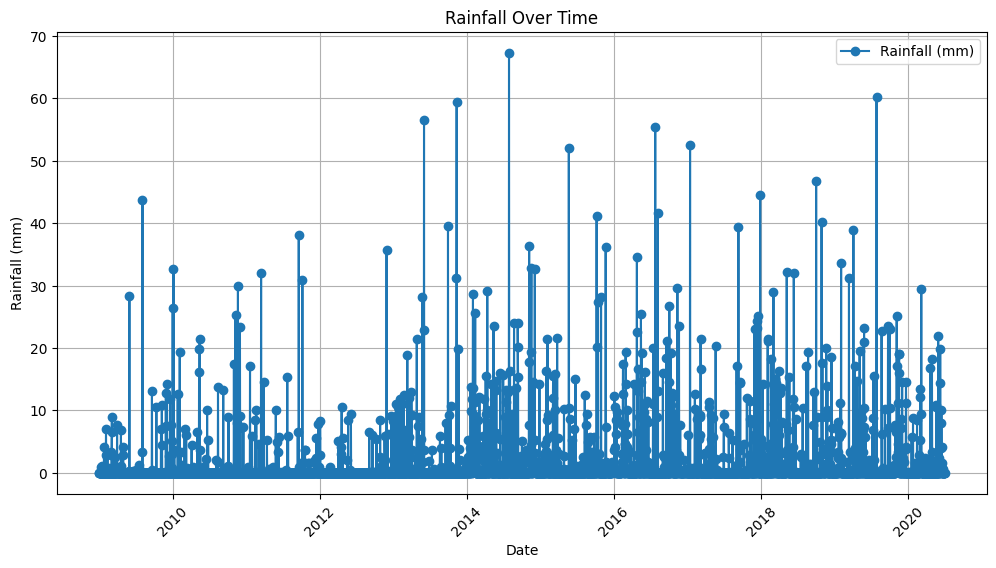

In [51]:

plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['rainfall'], marker='o', label='Rainfall (mm)')
plt.title('Rainfall Over Time')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Temperature Over Time

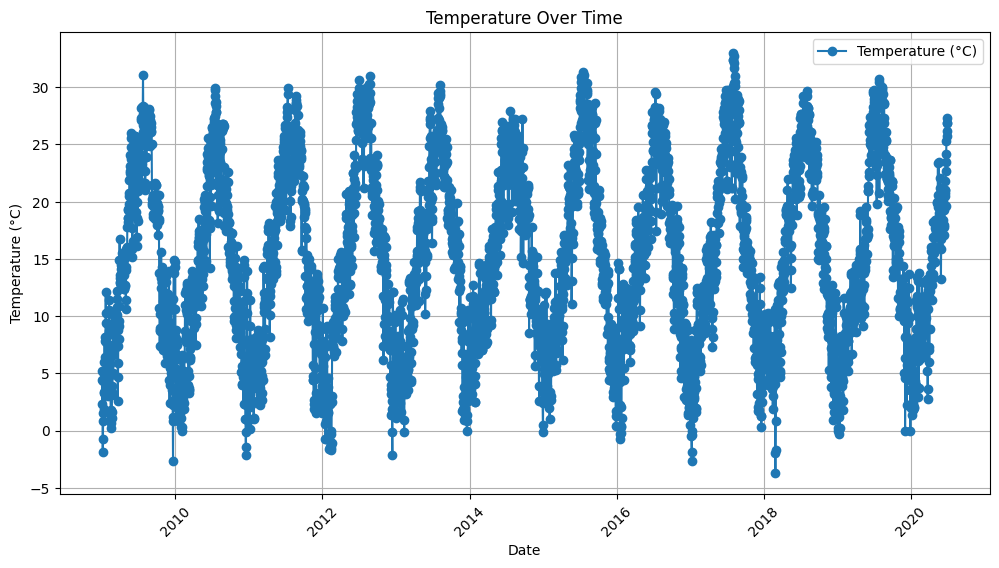

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['temperature'], marker='o', label='Temperature (°C)')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Volume Over Time

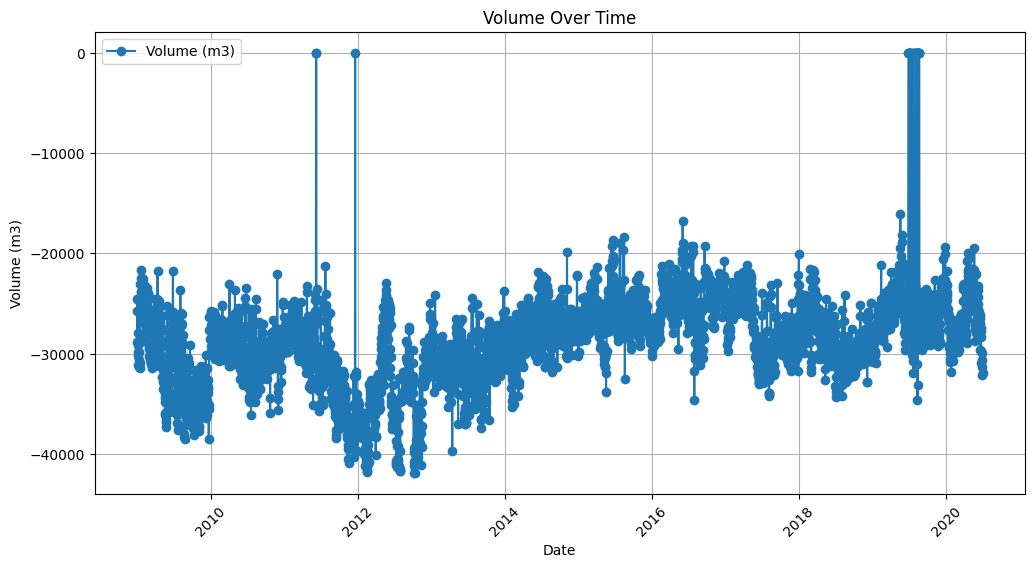

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['drainage_volume'], marker='o', label='Volume (m3)')
plt.title('Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume (m3)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Hidrometry over time

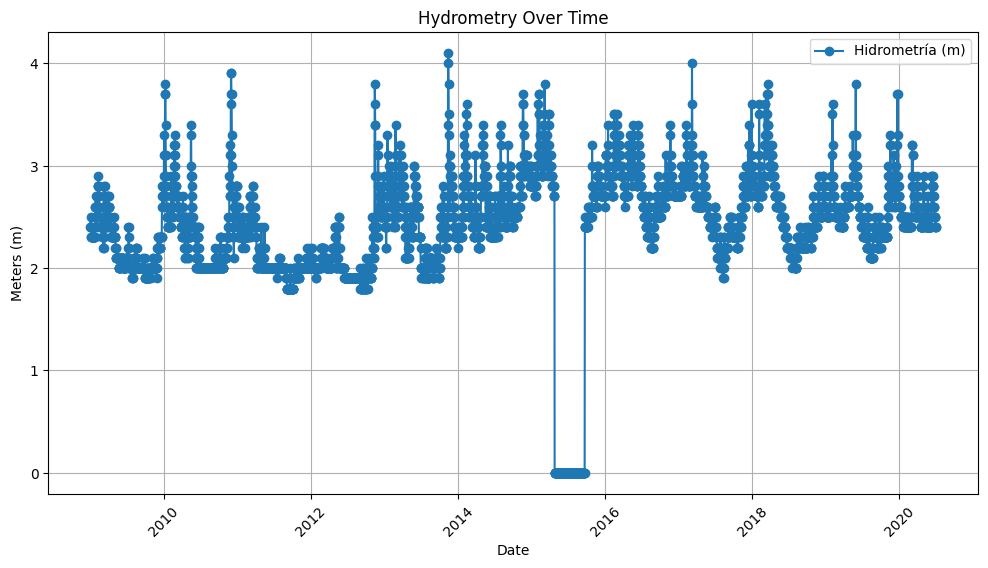

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['river_hydrometry'], marker='o', label='Hidrometría (m)')
plt.title('Hydrometry Over Time')
plt.xlabel('Date')
plt.ylabel('Meters (m)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

En varios casos, se ve picos en los datos que no son consistentes. Mi sospecha, observando los estudios de otros en Kaggle, es que hay varios valores nulos en los datos. 


In [55]:
df.isna().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

Se puede ver que en el último gráfico, hay un bajón debido a los datos faltantes. Los trataremos mas tarde, antes me gustaría graficar un plot multilinear para ver lluvia, temperatura, y profundidad para poder ver como interactuan en el tiempo. 

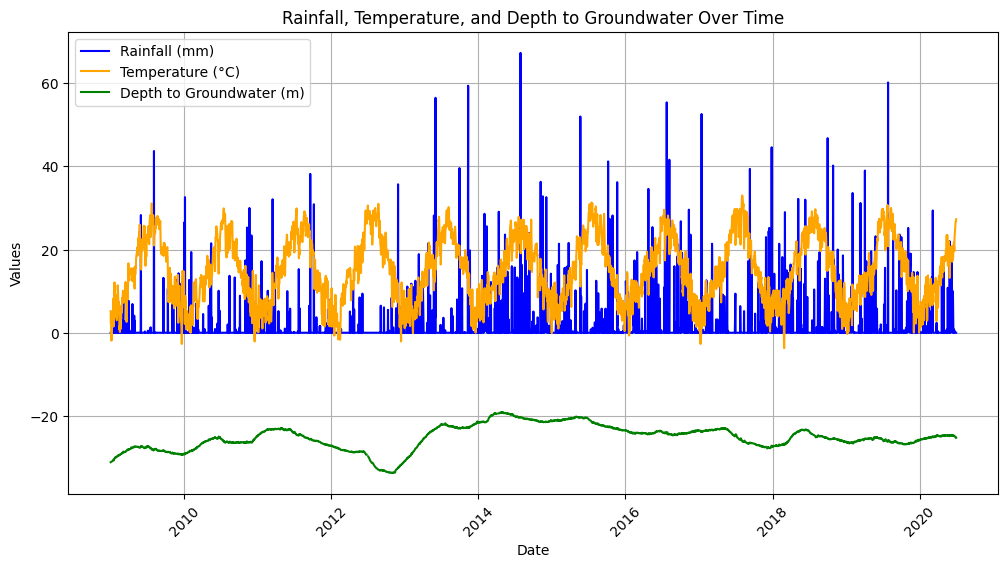

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['rainfall'], label='Rainfall (mm)', color='blue')
plt.plot(df['date'], df['temperature'], label='Temperature (°C)', color='orange')
plt.plot(df['date'], df['depth_to_groundwater'], label='Depth to Groundwater (m)', color='green')
plt.title('Rainfall, Temperature, and Depth to Groundwater Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Y con el fin de tener aún mas datos, un mapa de correlaciones también podría ayudarnos a tener una visión mas certera sobre el asunto: 

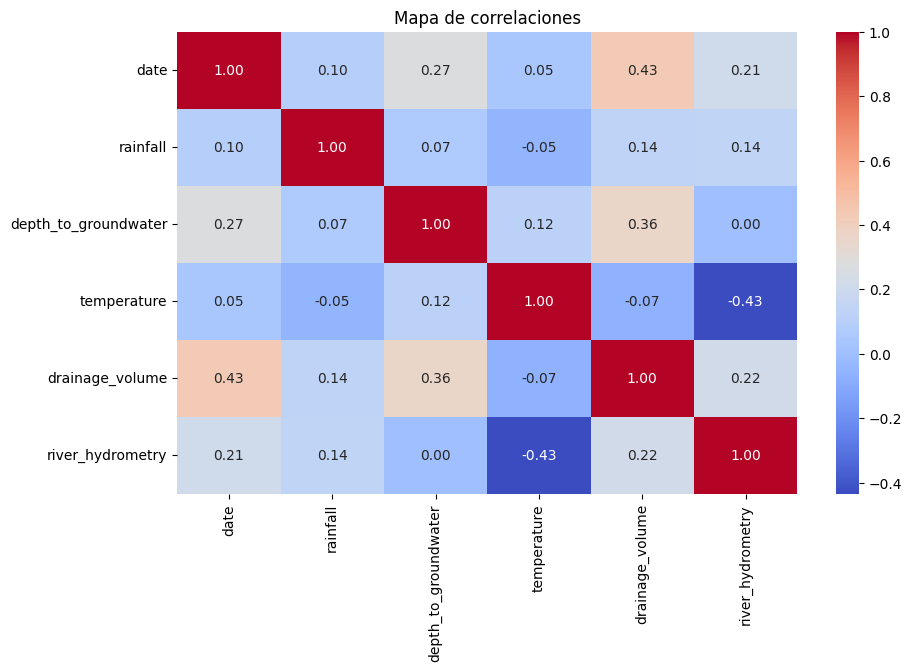

In [57]:
plt.figure(figsize=(10, 6))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de correlaciones')
plt.show()

Es particularmente llamativo: 

- La correlación negativa entre hidrometría y la temperatura del agua
- Que la correlación entre la fecha y el drenaje es el mismo número pero en positivo 
- La evidente correlación entre drenaje y profundidad del agua. Cuanto mas agua se drena, mayor profundidad

Volviendo al tema de los datos faltantes: 

In [58]:
df.isna().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

Tenemos varias alternativas para poder tratarlos, me resulta super instructiva la manera en la que en la solución se muestra, donde se exploran los 4 posibles escenarios: 

1 - Sustituir NaN con ceros

2 - Sustituir NaN con la media

3 - Sustituir NaN con el último valor usando .ffill()

4 - Sustituir NaN con Linearly Interpolated Value con .interpolate()


Así que sin esconderlo, voy a decir que he copiado el código porque visualmente me parece muy indicativo: 

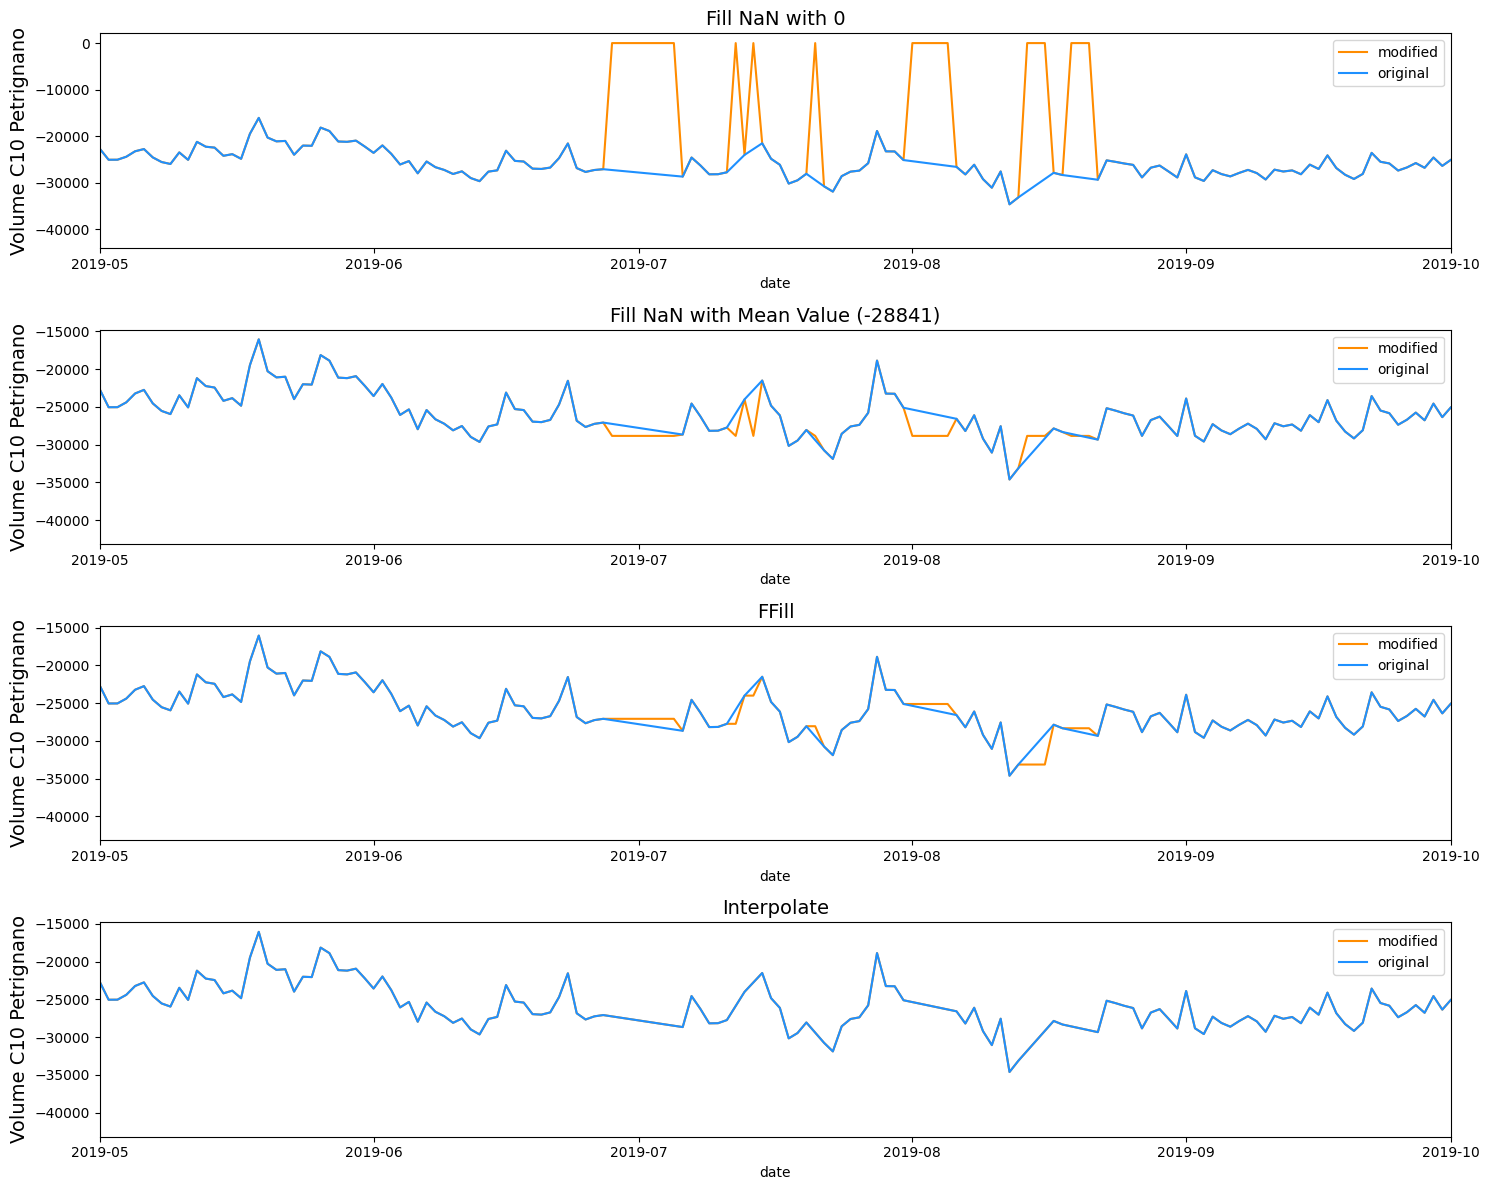

In [59]:
old_hydrometry = df['river_hydrometry'].copy()
df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)
old_drainage = df['drainage_volume'].copy()
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)

f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_drainage = df['drainage_volume'].mean()
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(mean_drainage), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_drainage:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])
    
plt.tight_layout()
plt.show()

Como se puede ver, donde menos estridencia hay, y menos presencia del color naranja, es a la hora de interpolar los datos. 

In [60]:
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

## Resampling
En nuestro caso con el fin de ampliar los datos, vamos a hacer la comparativa entre dias, semanas y meses

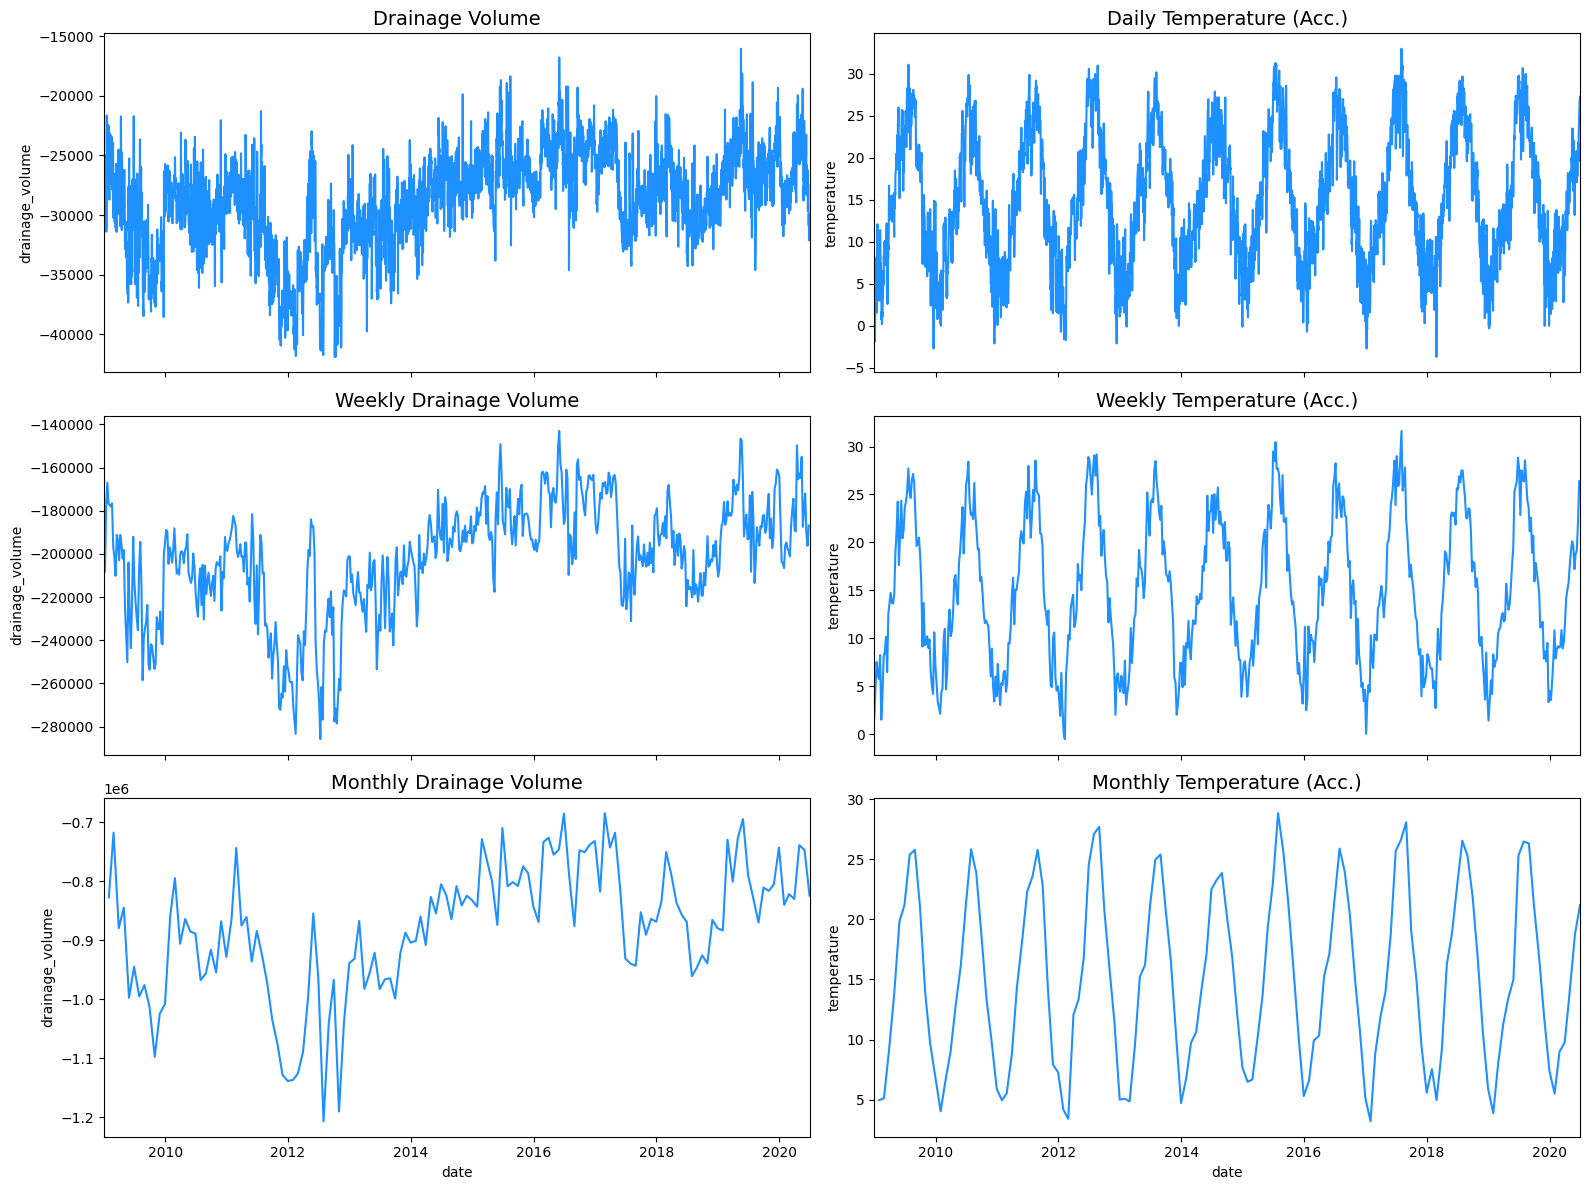

In [61]:

fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16, 12))

columns = ['drainage_volume', 'temperature']
resampling_frequencies = ['D', '7D', 'ME']  # Daily, Weekly, Monthly
titles = [
    'Drainage Volume',
    'Weekly Drainage Volume',
    'Monthly Drainage Volume',
    'Daily Temperature (Acc.)',
    'Weekly Temperature (Acc.)',
    'Monthly Temperature (Acc.)'
]

for col_index, column in enumerate(columns):
    # En base a los dias (Upsampling)
    sns.lineplot(x=df['date'], y=df[column], color='dodgerblue', ax=ax[0, col_index])
    ax[0, col_index].set_title(titles[col_index * 3], fontsize=14)

    # Resample and plot for 7D and M
    for freq_index, freq in enumerate(resampling_frequencies[1:], start=1):
        resampled_df = df[['date', column]].resample(freq, on='date').sum().reset_index(drop=False) if column == 'drainage_volume' else df[['date', column]].resample(freq, on='date').mean().reset_index(drop=False)
        sns.lineplot(x=resampled_df['date'], y=resampled_df[column], color='dodgerblue', ax=ax[freq_index, col_index])
        ax[freq_index, col_index].set_title(titles[col_index * 3 + freq_index], fontsize=14)

    # Set x-axis limits for all rows in the current column
    for i in range(3):
        ax[i, col_index].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

Como se puede ver, trabajar con datos semanales es una buena opción. Así que mantendremos esos datos.

In [62]:
downsample = df[['date',
                 'depth_to_groundwater', 
                 'temperature',
                 'drainage_volume', 
                 'river_hydrometry',
                 'rainfall'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()

## Stationarity 
 Para poder comprobar si los datos son estacionarios, podemos ejecutar el Dickey-Fuller Test y sacar estadísticas: 

In [63]:
from statsmodels.tsa.stattools import adfuller
ts = df["depth_to_groundwater"]
def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)

Dickey-Fuller test results:


Test Statistic                  -2.880202
p-value                          0.047699
#Lags Used                       7.000000
Number of Observations Used    592.000000
Critical Value (1%)             -3.441444
Critical Value (5%)             -2.866435
Critical Value (10%)            -2.569377
dtype: float64

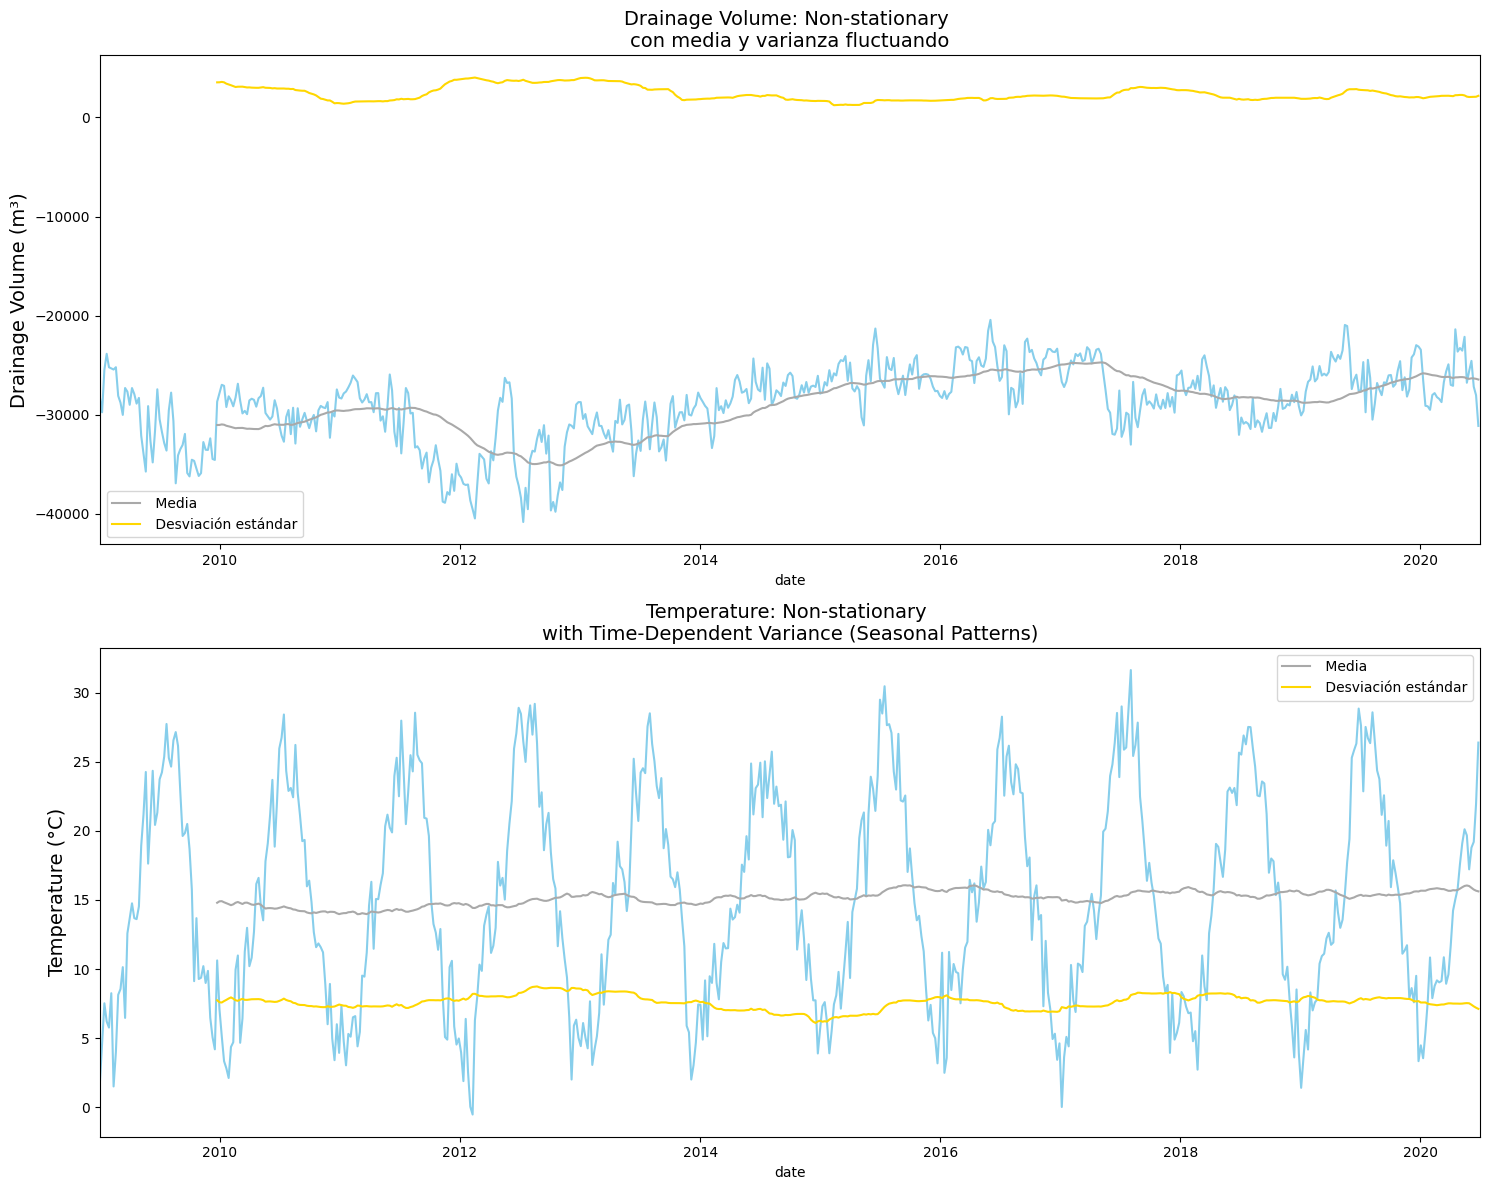

In [64]:
semanas = 52   #52 semanas al año
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

# Drainage volume
sns.lineplot(x=df['date'], y=df['drainage_volume'], ax=ax[0], color='skyblue')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(semanas).mean(), ax=ax[0], color='darkgray', label=' Media')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(semanas).std(), ax=ax[0], color='gold', label=' Desviación estándar')
ax[0].set_title('Drainage Volume: Non-stationary \ncon media y varianza fluctuando', fontsize=14)
ax[0].set_ylabel('Drainage Volume (m³)', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

# Ploteando la temperatura
sns.lineplot(x=df['date'], y=df['temperature'], ax=ax[1], color='skyblue')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(semanas).mean(), ax=ax[1], color='darkgray', label=' Media')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(semanas).std(), ax=ax[1], color='gold', label=' Desviación estándar')
ax[1].set_title('Temperature: Non-stationary \nwith Time-Dependent Variance (Seasonal Patterns)', fontsize=14)
ax[1].set_ylabel('Temperature (°C)', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

Se puede ver como (principalmente en el segundo gráfico) la media y la varianza no son constantes, pero están cerca de ello. 

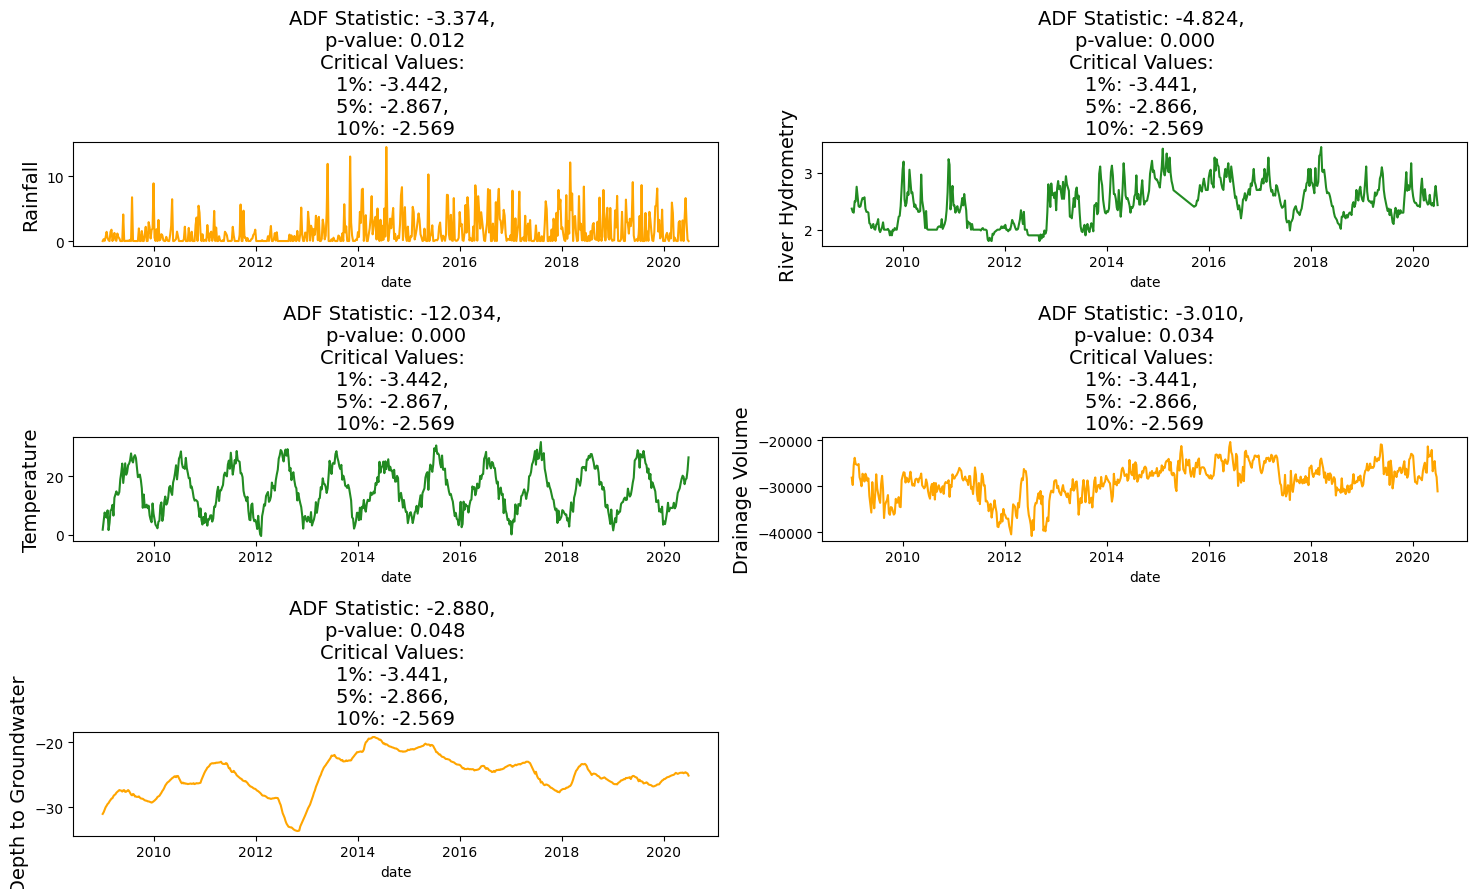

In [65]:
# Create subplots
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    adf_stat, p_val = result[0], result[1]
    crit_vals = result[4]
    
    # Adaptamos el color de la linea en ADF statistic y p-value
    if p_val < 0.05:
        if adf_stat < crit_vals['1%']:
            linecolor = 'forestgreen'
        elif adf_stat < crit_vals['5%']:
            linecolor = 'orange'
        elif adf_stat < crit_vals['10%']:
            linecolor = 'red'
        else:
            linecolor = 'purple'
    else:
        linecolor = 'purple'

    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic: {adf_stat:.3f}, \np-value: {p_val:.3f}\n'
                 f'Critical Values: \n1%: {crit_vals["1%"]:.3f}, \n5%: {crit_vals["5%"]:.3f}, \n10%: {crit_vals["10%"]:.3f}', 
                 fontsize=14)
    ax.set_ylabel(title, fontsize=14)

series_list = [
    (df['rainfall'].values, 'Rainfall', ax[0, 0]),
    (df['temperature'].values, 'Temperature', ax[1, 0]),
    (df['river_hydrometry'].values, 'River Hydrometry', ax[0, 1]),
    (df['drainage_volume'].values, 'Drainage Volume', ax[1, 1]),
    (df['depth_to_groundwater'].values, 'Depth to Groundwater', ax[2, 0])
]

for series, title, axis in series_list:
    visualize_adfuller_results(series, title, axis)

f.delaxes(ax[2, 1]) # Quitar el plot que no se usa

plt.tight_layout()
plt.show()

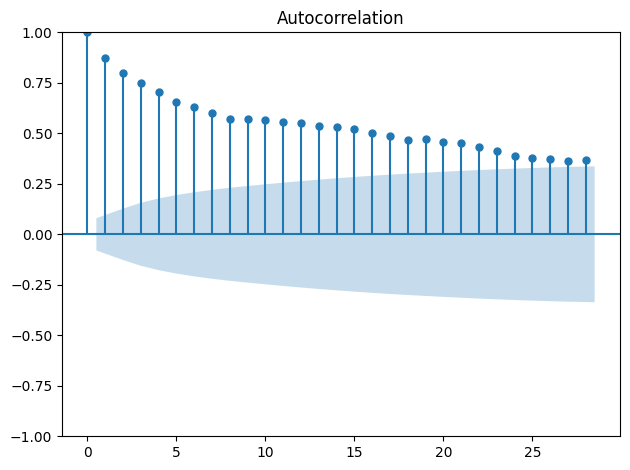

In [66]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['drainage_volume'])

plt.tight_layout()

plt.show()

## Autocorrelation Analysis

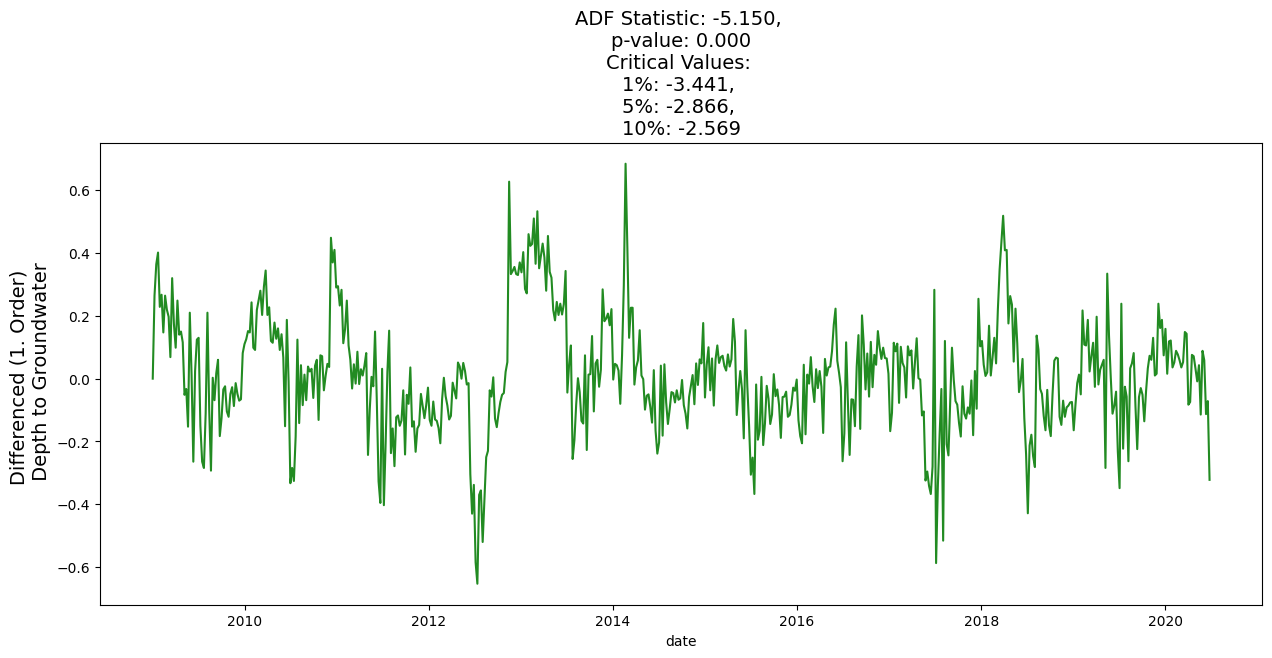

In [67]:
# First Order Differencing
ts_diff = np.diff(df['depth_to_groundwater'])
df['depth_to_groundwater_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['depth_to_groundwater_diff_1'], 'Differenced (1. Order) \n Depth to Groundwater', ax)



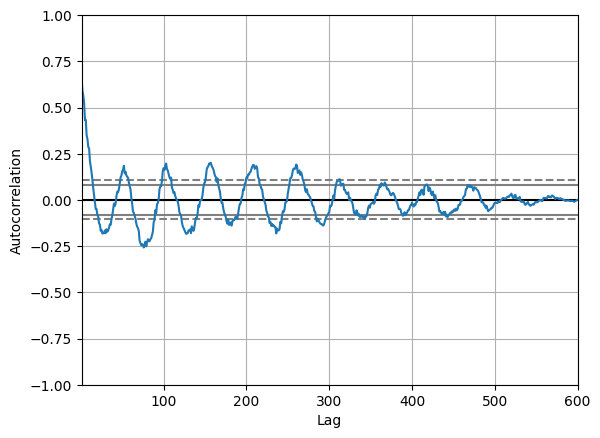

In [68]:
autocorrelation_plot(df['depth_to_groundwater_diff_1'])
plt.show()

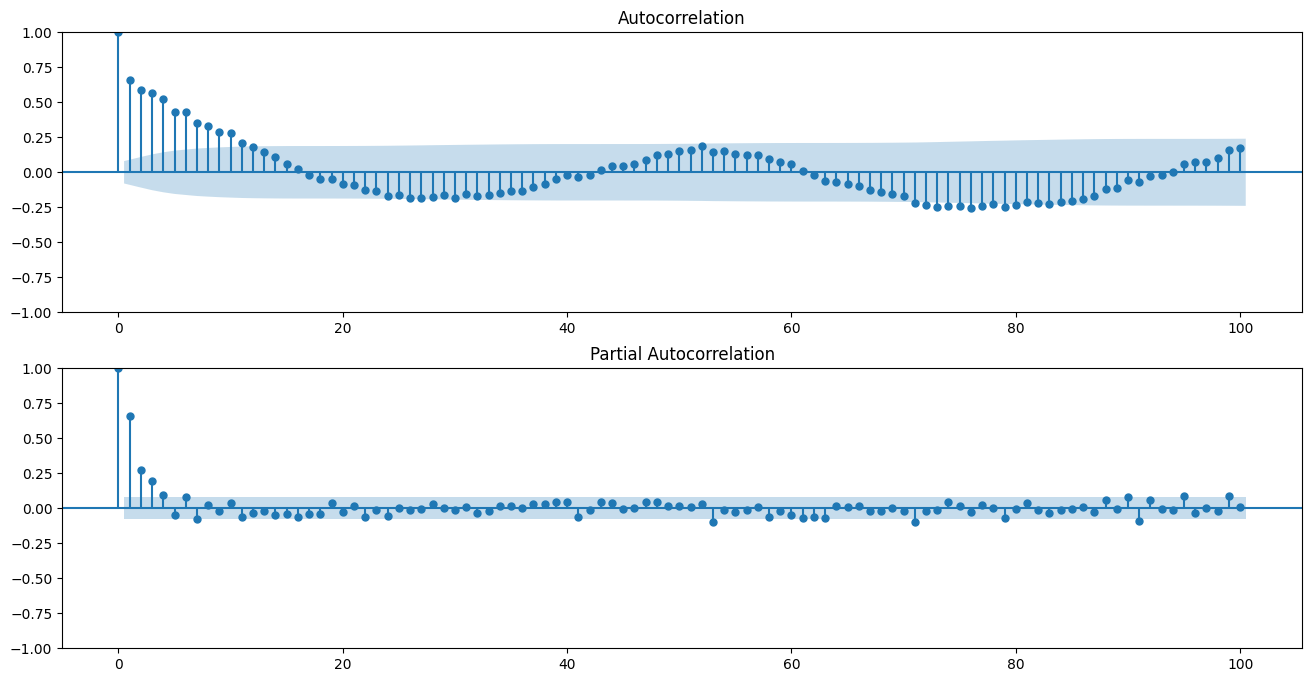

In [69]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[1])

plt.show()

## Modelado de datos

In [70]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['date']
y = df['depth_to_groundwater']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

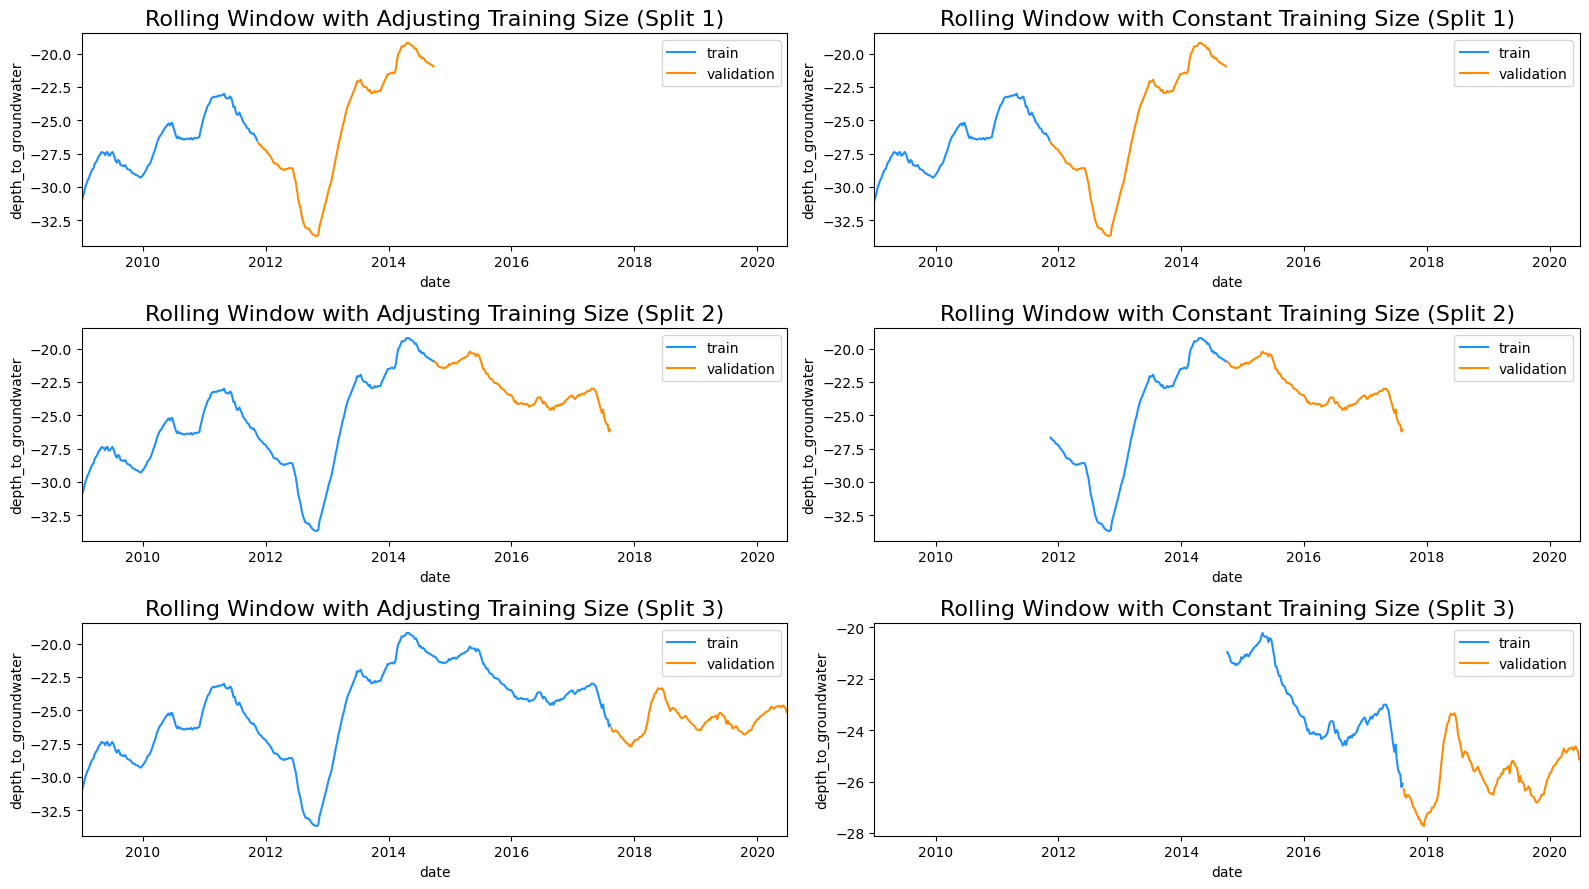

In [71]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

## Models for Univariate Time Series

In [72]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'depth_to_groundwater']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

510 90


### ARIMA 

In [73]:
from statsmodels.tsa.arima.model import ARIMA  
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Fit model
model = ARIMA(y_train, order=(1,1,1))
model_fit = model.fit()

# Prediction with ARIMA
forecast = model_fit.forecast(steps=90)  # En la nueva versión, el argumento se llama "steps"
y_pred = forecast  # Predicciones

# Calculate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print(f'RMSE: {score_rmse}')

RMSE: 1.4026242162573213


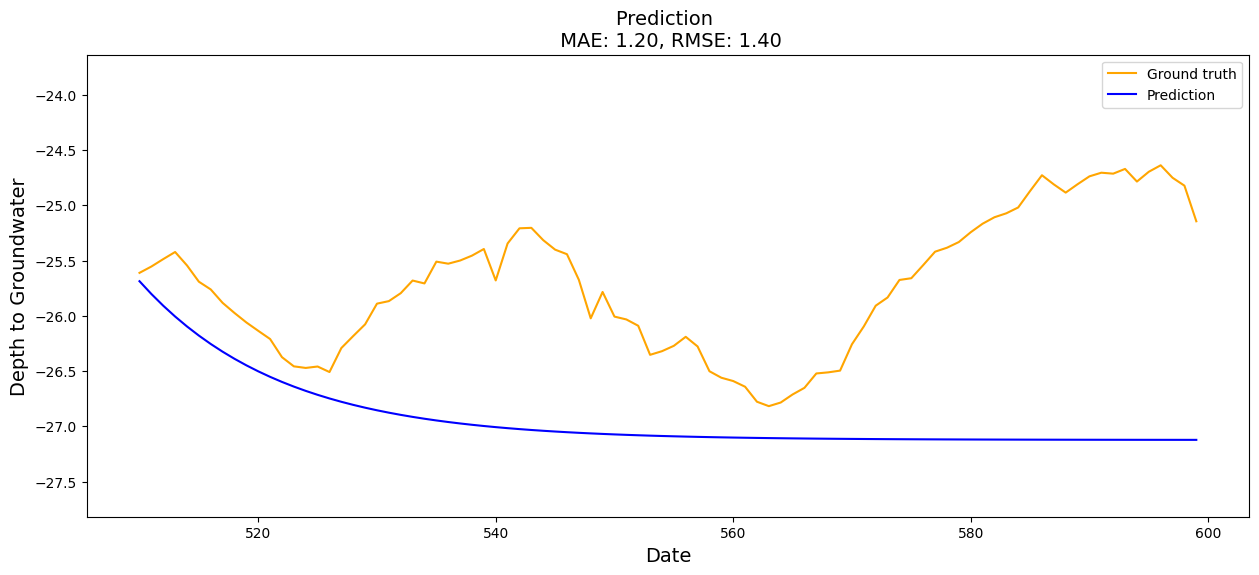

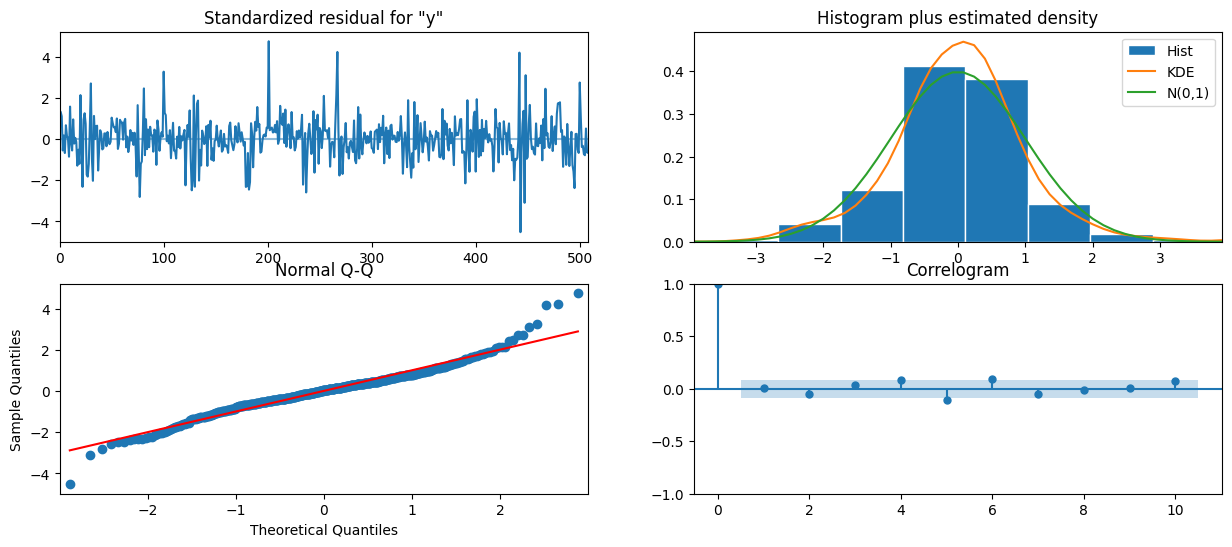

In [74]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

# Graficar predicción
model_fit.plot_diagnostics(figsize=(15, 6))

# Forecast plot (reemplazo de plot_predict)
y_forecast = model_fit.forecast(steps=len(y_valid))

# Validación
sns.lineplot(x=y_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth')
sns.lineplot(x=y_valid.index, y=y_forecast, ax=ax, color='blue', label='Prediction')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

ax.set_ylim(y_valid['y'].min() - 1, y_valid['y'].max() + 1)
ax.legend()
plt.show()


In [82]:
print(y_train.head())


           y
0 -31.048571
1 -30.784286
2 -30.420000
3 -30.018571
4 -29.790000


## La compatibilidad entre Numpy y Arima da fallos, debido a que han cambiado el modelo. He tratado de instalar las versiones especificas pero no he logrado nada. 

In [87]:
#from statsmodels.tsa.arima.model import ARIMA
#import pmdarima as pm

# Ajuste del modelo ARIMA usando pmdarima
#model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      #test='adf',       # usará ADF para encontrar el valor óptimo de 'd'
                      #max_p=3, max_q=3, # máximo valor para p y q
                      #m=1,               # frecuencia de la serie
                      #d=None,            # permite que el modelo determine 'd'
                      #seasonal=False,    # No estacionalidad
                      #trace=True,        # Mostrar el progreso del ajuste
                      #error_action='ignore',  
                      #suppress_warnings=True, 
                      #stepwise=True)

# Resumen del modelo ajustado
#print(model.summary())



In [86]:
#model.plot_diagnostics(figsize=(16,8))
#plt.show()

## LTSM recurrent neural network

The following data pre-processing and feature engineering need to be done before constructing the LSTM model.

Create the dataset, ensure all data is float.

Normalize the features.

Split into training and test sets.

Convert an array of values into a dataset matrix.

Reshape into X=t and Y=t+1.

Reshape input to be 3D (num_samples, num_timesteps, num_features).

In [88]:
# Escalar los datos

from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])
# Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.81796644],
       [-0.79970385],
       [-0.7745311 ],
       [-0.74679171],
       [-0.73099704],
       [-0.71253702],
       [-0.7023692 ],
       [-0.68410661],
       [-0.66890424],
       [-0.65528134]])

In [89]:
# Defines the rolling window
look_back = 52
# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

406 90


In [93]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

2025-02-19 11:03:25.222577: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-19 11:03:25.246007: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-19 11:03:26.555501: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-19 11:03:26.707141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739963007.207212    6519 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739963007.24

Epoch 1/5


2025-02-19 11:03:34.603767: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/vscode/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


406/406 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0241 - val_loss: 6.9044e-04
Epoch 2/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 3/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 4/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0026 - val_loss: 3.2784e-04
Epoch 5/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015 - val_loss: 0.0010


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 431,195 (1.64 MB)

 Trainable params: 143,731 (561.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 287,464 (1.10 MB)

### Predecimos con el modelo

In [97]:

from colorama import Fore
# Invertir las predicciones
train_predict = scaler.inverse_transform(train_predict)

# Asegurarte de que y_train sea 2D (reshape a 2D si es necesario)
y_train_reshaped = y_train.reshape(-1, 1)
y_train = scaler.inverse_transform(y_train_reshaped)

test_predict = scaler.inverse_transform(test_predict)

# Asegurarte de que y_test sea 2D (reshape a 2D si es necesario)
y_test_reshaped = y_test.reshape(-1, 1)
y_test = scaler.inverse_transform(y_test_reshaped)

# Obtener el RMSE y MAE
score_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
score_mae = mean_absolute_error(y_test, test_predict)

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))
print(Fore.GREEN + 'MAE: {}'.format(score_mae))


RMSE: 5288.551265321016
MAE: 5287.184255022763


## Models for Multivariate Time Series

In [104]:
feature_columns = [
    'rainfall',
    'temperature',
    'drainage_volume',
    'river_hydrometry',
]
target_column = ['depth_to_groundwater']

train_size = int(0.85 * len(df))

multivariate_df = df[['date'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

,ds,y,rainfall,temperature,drainage_volume,river_hydrometry
0,2009-01-01,-31.048571,0.000000,1.657143,-28164.918857,2.371429
1,2009-01-08,-30.784286,0.285714,4.571429,-29755.789714,2.314286
2,2009-01-15,-30.420000,0.028571,7.528571,-25463.190857,2.300000
3,2009-01-22,-30.018571,0.585714,6.214286,-23854.422857,2.500000
4,2009-01-29,-29.790000,1.414286,5.771429,-25210.532571,2.500000


In [106]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Crear el modelo de Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo con el conjunto de entrenamiento
model_rf.fit(train[['rainfall', 'temperature', 'drainage_volume', 'river_hydrometry']], train['y'])

# Predecir en el conjunto de validación
y_pred_rf = model_rf.predict(x_valid[['rainfall', 'temperature', 'drainage_volume', 'river_hydrometry']])

# Calcular las métricas
score_mae_rf = mean_absolute_error(y_valid, y_pred_rf)
score_rmse_rf = math.sqrt(mean_squared_error(y_valid, y_pred_rf))

# Imprimir las métricas
print('Random Forest RMSE: {}'.format(score_rmse_rf))
print('Random Forest MAE: {}'.format(score_mae_rf))


Random Forest RMSE: 1.864792458708561
Random Forest MAE: 1.5587819365079354


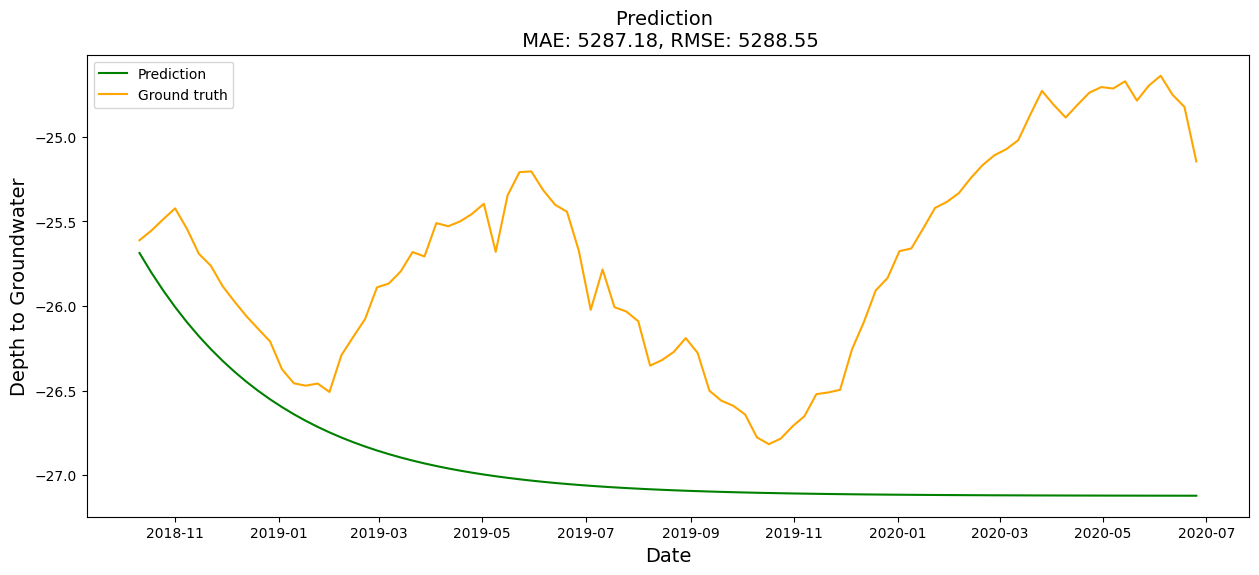

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_valid['ds'], y=y_pred, ax=ax, color='green', label='Prediction')

# Graficar la verdad de los datos de validación
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Depth to Groundwater', fontsize=14)

plt.show()
